# Figure 3 - Static displacement of the 2021 Mw 7.4 Maduo EQ

Need the results from:
1. [prep_az_off.ipynb](./1_prep_az_off.ipynb)
2. [prep_rg_off.ipynb](./2_prep_rg_off.ipynb)
3. [prep_ifgram.ipynb](./3_prep_ifgram.ipynb)
4. [defo3d.ipynb](./4_defo3d.ipynb)

In [1]:
%matplotlib inline
import os
import numpy as np
from matplotlib import pyplot as plt
from cartopy import crs as ccrs
from mintpy.utils import readfile, utils as ut, plot as pp
from mintpy import view
plt.rcParams.update({'font.size': 12})

work_dir = os.path.expanduser('~/data/archives/2021MaduoEQ/data')
os.chdir(work_dir)
print('Go to directory:', work_dir)

# input files
S, N, W, E = 33.9, 35.4, 97.1, 99.7
dem_file = os.path.join(work_dir, '../DEM/demLat_N33_N36_Lon_E096_E101.dem')
enu_file = os.path.join(work_dir, 'dis_enu.h5')
rg_off_file = os.path.join(work_dir, 'SenAT099_20210520_20210526_OFF_RG/rgOff.geo')

# main rupture trace
ll_file = os.path.join(work_dir, 'Main_rupture_LL.gmt')
faults = readfile.read_gmt_lonlat_file(ll_file)

# fault boundary
fault_b_file = os.path.join(work_dir, 'fault_b')
fault_bs = readfile.read_gmt_lonlat_file(fault_b_file)

# reference point [the same as the multiple 1D maps used in the Finite Fault Inversion by Xu]
rlat, rlon = 34.2, 97.3
print(f'reference point: N {float(rlat):.2f}, E {float(rlon):.2f}')

Go to directory: /Users/yunjunz/data/archives/2021MaduoEQ/data
[==================================================] line 21 / 21 
[==================================================] line 18 / 18 
reference point: N 34.20, E 97.30


## Fig. 3a - 3D deformation from InSAR and azimuth offset

In [2]:
# prep displacement up
cmd = f'view.py {enu_file} up -c RdBu -v -0.3 0.3 --noverbose --notitle --fontsize 12 --nocbar '
cmd += f' --sub-lat {S} {N} --sub-lon {W} {E} -d {dem_file} --shade-max 7500 --scalebar 0.2 0.84 0.06 '
cmd += f' --ref-lalo {rlat} {rlon} --ref-size 3 '
dis_u, atr, inps = view.prep_slice(cmd)

# prep displacement east / north
lats, lons = ut.get_lat_lon(atr, box=inps.pix_box, dimension=1)
dis_e = readfile.read(enu_file, datasetName='east',  box=inps.pix_box)[0]
dis_n = readfile.read(enu_file, datasetName='north', box=inps.pix_box)[0]
# referencing
ry, rx = ut.coordinate(atr).geo2radar(rlat, rlon)[:2]
ry -= inps.pix_box[1]
rx -= inps.pix_box[0]
dis_e -= dis_e[ry, rx]
dis_n -= dis_n[ry, rx]

view.py /Users/yunjunz/data/archives/2021MaduoEQ/data/dis_enu.h5 up -c RdBu -v -0.3 0.3 --noverbose --notitle --fontsize 12 --nocbar --sub-lat 33.9 35.4 --sub-lon 97.1 99.7 -d /Users/yunjunz/data/archives/2021MaduoEQ/data/../DEM/demLat_N33_N36_Lon_E096_E101.dem --shade-max 7500 --scalebar 0.2 0.84 0.06 --ref-lalo 34.2 97.3 --ref-size 3


save figure to file /Users/yunjunz/data/archives/2021MaduoEQ/data/dis_3d.png


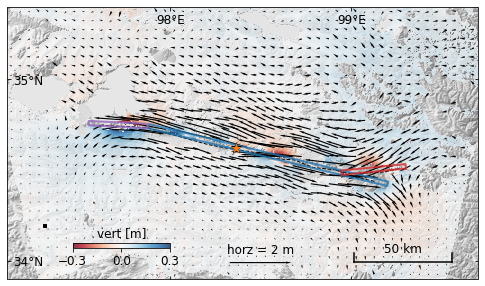

In [3]:
cs = ['C0', 'C4', 'C3']  # hex color 1f77b4, 9467bd, d62728. They are close to GMT colors darkblue, purple and darkred
fig, ax = plt.subplots(figsize=[9, 5], subplot_kw=dict(projection=ccrs.PlateCarree()))

# plot vert displacement
ax, inps, im, cbar = view.plot_slice(ax, dis_u, atr, inps)
pp.draw_lalo_label(ax, inps.geo_box, lalo_step=inps.lalo_step, lalo_loc=[1, 0, 1, 0], lalo_max_num=inps.lalo_max_num,
                   font_size=inps.font_size, projection=inps.map_proj_obj, print_msg=inps.print_msg, lalo_offset=(-36, -20))

# plot horz displacement
step = 60
Q = ax.quiver(lons[int(step/2)::step], lats[int(step/2)::step],
              dis_e[int(step/2)::step, int(step/2)::step],
              dis_n[int(step/2)::step, int(step/2)::step], headwidth=2., alpha=1.0)

# plot rupture traces, fault boundaries, hypocenter
for i, fault in enumerate(faults):      ax.plot(fault[:,0], fault[:,1], '--', lw=1, color='k')
for i, (fault_b, c) in enumerate(zip(fault_bs, cs)):    ax.plot(fault_b[:,0], fault_b[:,1], '-', color=c, lw=2, alpha=0.8)
ax.scatter(98.362, 34.620, s=12**2, marker='*', c='C1', edgecolors='k', lw=0.3, zorder=10)

# axis format
cax = fig.add_axes([0.25, 0.21, 0.15, 0.015])
cbar = fig.colorbar(im, cax=cax, orientation='horizontal', ticks=[-0.3, 0, 0.3])
cbar.ax.set_title('vert [m]', fontsize=12)
ax.quiverkey(Q, X=0.54, Y=0.17, U=2, label='horz = 2 m', labelsep=0.08, coordinates='figure')

# output
out_fig = os.path.abspath('dis_3d.png')
print('save figure to file', out_fig)
plt.savefig(out_fig, bbox_inches='tight', transparent=True, dpi=600)
plt.show()

## Fig. 3b - Near field displacement from range offset

In [4]:
# prep displacement up
cmd = f'view.py {rg_off_file} -c RdBu -v -1.2 1.2 --noverbose --notitle --fontsize 12 --nocbar '
cmd += f' --sub-lat {S} {N} --sub-lon {W} {E} -d {dem_file} --shade-max 7500 --scalebar 0.2 0.84 0.06 '
cmd += f' --ref-lalo {rlat} {rlon} --ref-size 3 '
dis_rg, atr, inps = view.prep_slice(cmd)

view.py /Users/yunjunz/data/archives/2021MaduoEQ/data/SenAT099_20210520_20210526_OFF_RG/rgOff.geo -c RdBu -v -1.2 1.2 --noverbose --notitle --fontsize 12 --nocbar --sub-lat 33.9 35.4 --sub-lon 97.1 99.7 -d /Users/yunjunz/data/archives/2021MaduoEQ/data/../DEM/demLat_N33_N36_Lon_E096_E101.dem --shade-max 7500 --scalebar 0.2 0.84 0.06 --ref-lalo 34.2 97.3 --ref-size 3


save figure to file /Users/yunjunz/data/archives/2021MaduoEQ/data/dis_rg.png


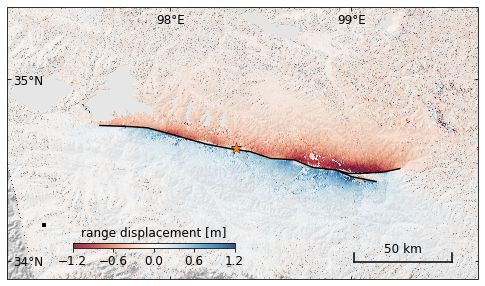

In [5]:
fig, ax = plt.subplots(figsize=[9, 5], subplot_kw=dict(projection=ccrs.PlateCarree()))

# plot vert displacement
ax, inps, im, cbar = view.plot_slice(ax, dis_rg, atr, inps)
pp.draw_lalo_label(ax, inps.geo_box, lalo_step=inps.lalo_step, lalo_loc=[1, 0, 1, 0], lalo_max_num=inps.lalo_max_num,
                   font_size=inps.font_size, projection=inps.map_proj_obj, print_msg=inps.print_msg, lalo_offset=(-36, -20))

# plot rupture traces, fault boundaries, hypocenter
for i, fault in enumerate(faults):   ax.plot(fault[:,0], fault[:,1], '-', lw=1.5, color='k')
ax.scatter(98.362, 34.620, s=12**2, marker='*', c='C1', edgecolors='k', lw=0.3, zorder=10)

# axis format
cax = fig.add_axes([0.25, 0.21, 0.25, 0.015])
cbar = fig.colorbar(im, cax=cax, orientation='horizontal', ticks=[-1.2, -0.6, 0, 0.6, 1.2])
cbar.ax.set_title('range displacement [m]', fontsize=12)

# output
out_fig = os.path.abspath('dis_rg.png')
print('save figure to file', out_fig)
plt.savefig(out_fig, bbox_inches='tight', transparent=True, dpi=600)
plt.show()